In [1]:
import os
import zipfile
import json
import pandas as pd
import math
import rioxarray
import geopandas
import seaborn as sns
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool
import numpy as np

## Gather data from floods

Each flood event in flood database consists of flood levels in a tif file and associated metadata in a json file.

Flood data is downloadable with instructions from https://github.com/cloudtostreet/MODIS_GlobalFloodDatabase or as individual flood files from https://global-flood-database.cloudtostreet.ai/.

In [113]:
flood_db_path = 'flood_db\\gfd_v1_4'

def load_flood_properties(file):
    '''Loads properties and bounding box coordinates for a flood event from flood db'''
    with zipfile.ZipFile(file) as z:
        json_file = [file_name for file_name in z.namelist() if file_name.endswith('.json')]
        with z.open(json_file[0]) as f:
            data = f.read()
            properties = json.loads(data)
            properties['fname'] = file

        tif_file = [file_name for file_name in z.namelist() if file_name.endswith('.tif')]
        # Extract tif files for processing
        # Some flood may contain multiple tifs, read only first
        z.extract(tif_file[0], 'temp')
        with rioxarray.open_rasterio('temp/' + tif_file[0]).squeeze() as data:
            properties['xmin'] = data.coords['x'].min().values
            properties['xmax'] = data.coords['x'].max().values
            properties['ymin'] = data.coords['y'].min().values
            properties['ymax'] = data.coords['y'].max().values

    return(properties)

In [114]:
properties_list = [load_flood_properties(flood_db_path + '\\' + fname) for fname in os.listdir(flood_db_path)]
floods_df = pd.DataFrame(properties_list)
floods_df.to_csv('floods.tsv', sep = '\t')

## Estimate probability of capturing a flood

Satellite on a polar orbit has a change of flying over a area that is tied to circumference of earth at the events latitude.

A flood event is considered captured by satellite if floods centroid coordinates were within satellites swath width.

Capture probability is calculated per cycle and probability each cycle is considered independent of each other. This seems appropriate as
- We are considering a short time frame 24h even if given enough orbits satellite would deterministically scan any area.
- Flood widths are small compared to distances between scans of consecutive orbits.

In [72]:
R = 6371
cycle_days = 12
orbits_per_cycle = 175
n_satellites = 1

def radius_at_lat(lat):
    return math.sin(math.pi/2 - math.radians(lat)) * R

def circumference_at_lat(lat):
    r = radius_at_lat(lat)
    return 2*math.pi*r

def prob_per_orbit(lat, swath_width):
    circ = circumference_at_lat(lat)
    if (circ == 0):
        return(1)
    if (swath_width > circumference_at_lat(lat)):
        return(1)

    return (swath_width) / circumference_at_lat(lat)

def prob_per_timeframe(lat, swath_width, time=24):
    p = prob_per_orbit(lat, swath_width)
    # Satellite passes any longitude line twice in one orbit
    passes_per_orbit = 2
    orbits = orbits_per_cycle / cycle_days * time / 24 * passes_per_orbit * n_satellites
    return(1-pow(1-p, orbits))

In [73]:
swath_width = 400
floods_df['capture_p_in_24h'] = floods_df.apply(lambda x: prob_per_timeframe(x['dfo_centroid_y'], swath_width), axis=1)
floods_df.to_csv('floods_df.tsv', sep = '\t')

## Features

Calculate flood sizes from bounding box and derive new variables from existing properties.

In [106]:
# Some issue using projection where distances are better calculated.
# Lat lon distances could still be useful for our model
ll = geopandas.points_from_xy(x=floods_df['xmin'], y=floods_df['ymin'], crs=4326)#.to_crs(1029)
ul = geopandas.points_from_xy(x=floods_df['xmin'], y=floods_df['ymax'], crs=4326)#.to_crs(1029)
ur = geopandas.points_from_xy(x=floods_df['xmax'], y=floods_df['ymax'], crs=4326)#.to_crs(1029)

floods_df['flood_width'] = ul.distance(ur)
floods_df['flood_height'] = ll.distance(ul)
floods_df['flood_area'] = floods_df['flood_width'] * floods_df['flood_height']

c:\Users\ville.koponen\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py:3308: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [88]:
pd.set_option('display.max_rows', None)
floods_df['dfo_main_cause'].value_counts()

dfo_main_cause
Heavy rain                             321
Heavy Rain                             189
Monsoonal rain                          81
Torrential Rain                         73
Monsoonal Rain                          55
Tropical cyclone                        32
Snowmelt                                25
Rain and snowmelt                       11
Tropical Cyclone                        10
Brief torrential rain                    8
Heavy Rain and Snowmelt                  6
Dam/Levy, break or release               6
Monsoon Rains                            4
Heavy monsoon rains                      3
Ice jam/break-up                         3
Snow Melt                                3
Monsoon Rain                             2
Heavy seasonal rains                     2
Tropical Storm Fung-Wong                 2
Tropical Storm                           2
Tropical Storm Trudy                     1
Monoonal Rain                            1
Monsoonal Ran                          

In [98]:
floods_df['n_countries_affected'] = floods_df.apply(lambda x: len(x['gfd_country_name'].split(',')), axis=1)
floods_df['n_causes'] = floods_df.apply(lambda x: len(x['dfo_main_cause'].split(',')), axis=1)

def deduct_main_cause(causes):
    '''Collate typical flood causes and spellings '''
    if 'dam' in causes.lower():
        return 'dam'
    if ('storm' in causes.lower() or
        'stom' in causes.lower() or
        'strom' in causes.lower() or
        'hurricane' in causes.lower() or
        'typhoon' in causes.lower() or
        'cyclone' in causes.lower()):
        return 'storm'
    if ('rain' in causes.lower() or
        'ran' in causes.lower()):
        return 'rain'
    if 'snow' in causes.lower() or 'ice' in causes.lower():
        return 'snow'
    return 'other'

floods_df['main_cause'] = floods_df.apply(lambda x: deduct_main_cause(x['dfo_main_cause']), axis=1)
floods_df.to_csv('floods_df.tsv', sep = '\t')


In [99]:
floods_df.loc[floods_df['main_cause'] == 'other']['dfo_main_cause'].value_counts()

dfo_main_cause
Tsunami    1
Name: count, dtype: int64

In [100]:
columns=['capture_p_in_24h', 'dfo_centroid_y', 'dfo_centroid_x', 'flood_width','flood_height', 'flood_area', 'dfo_severity', 'n_countries_affected', 'dfo_displaced', 'dfo_dead']

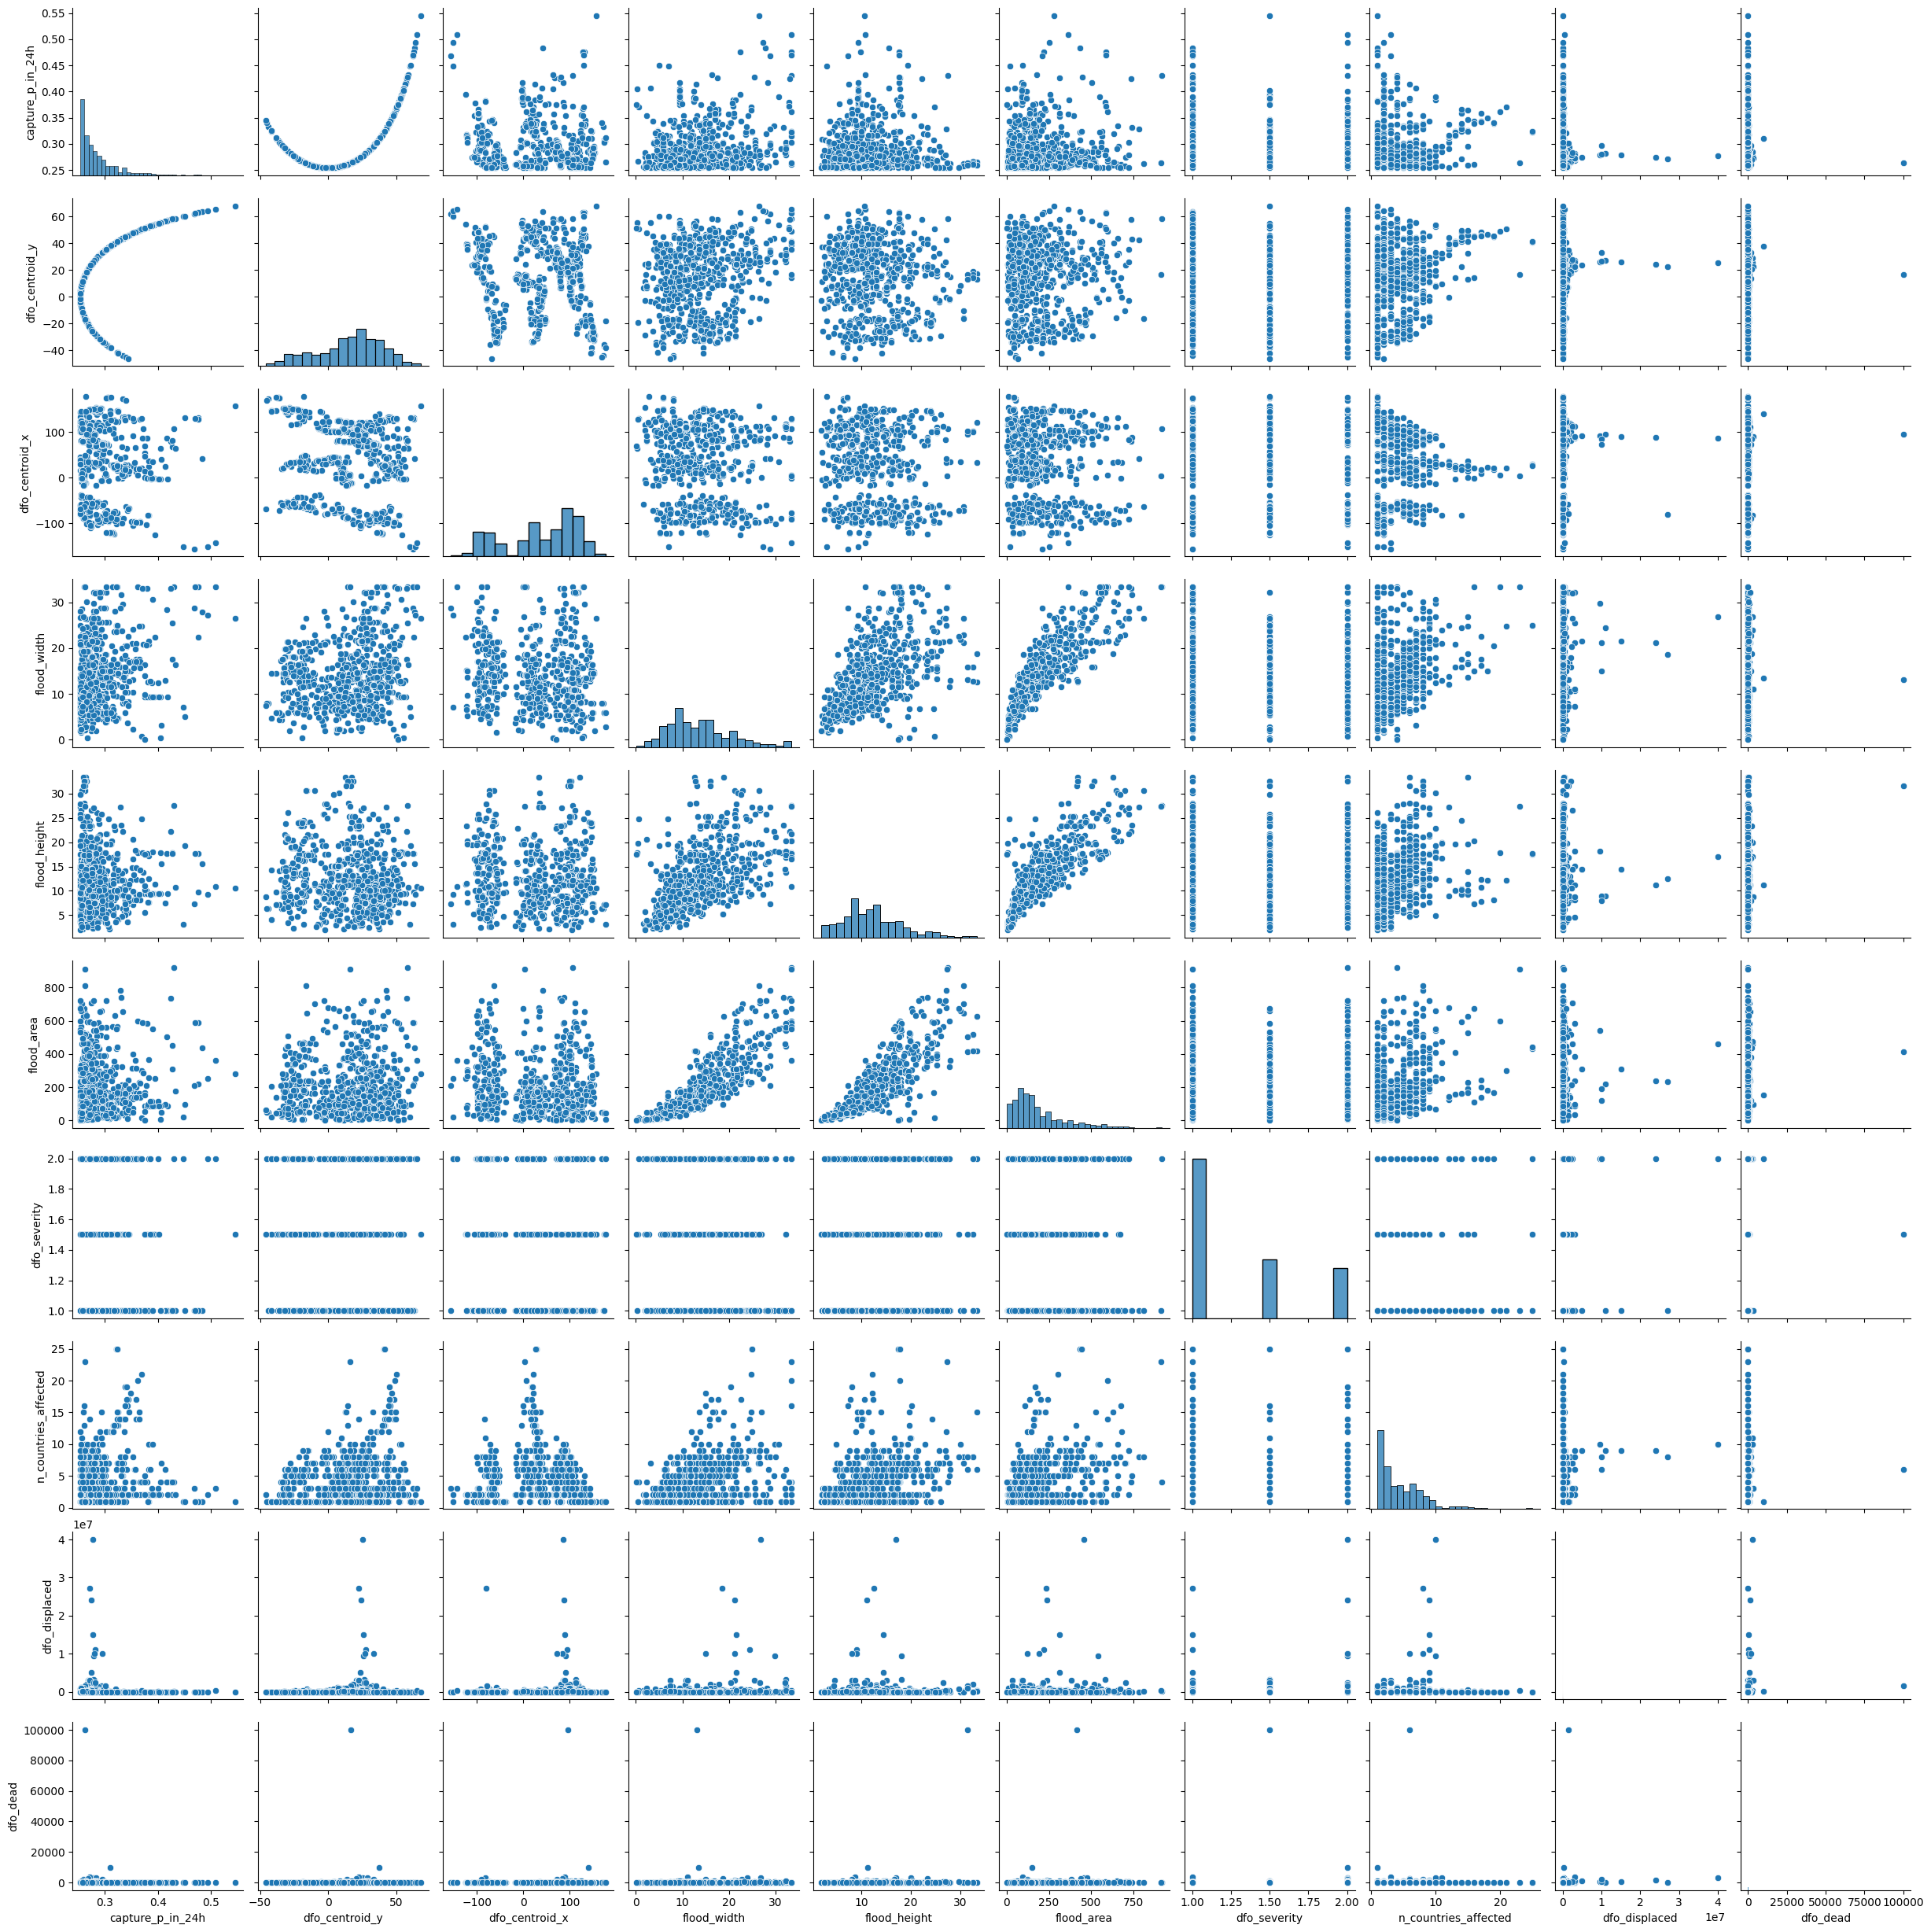

In [101]:
sns.pairplot(floods_df.filter(columns));

<Axes: >

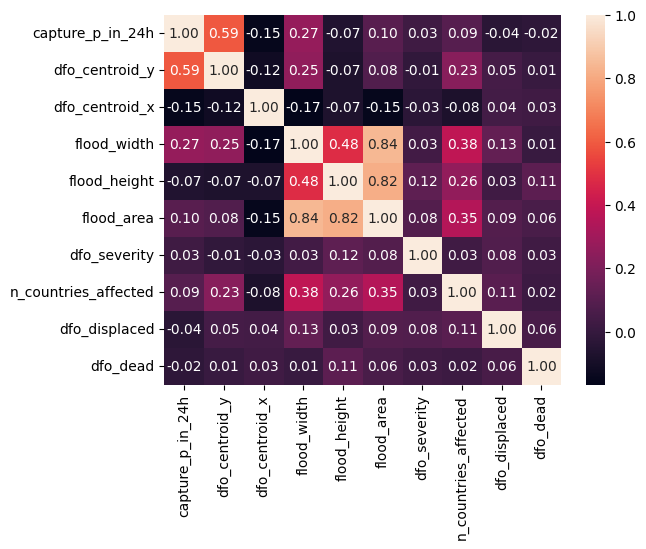

In [102]:
sns.heatmap(floods_df.filter(columns).corr(), annot = True, fmt = '.2f')

<Axes: xlabel='capture_p_in_24h', ylabel='main_cause'>

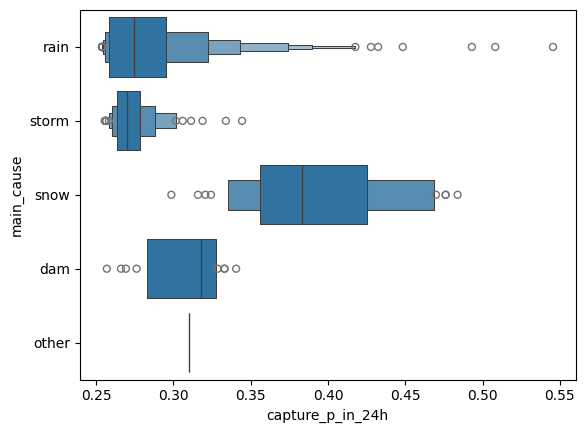

In [103]:
sns.boxenplot(data=floods_df, x="capture_p_in_24h", y="main_cause")

In [104]:
floods_df["dfo_country"].unique()
big_countries = floods_df.loc[floods_df["dfo_country"].isin(['Australia', 'China', 'Russia', 'USA', 'Germany', 'France', 'Brazil', 'Japan', 'United Kingdom'])]

<Axes: xlabel='capture_p_in_24h', ylabel='dfo_country'>

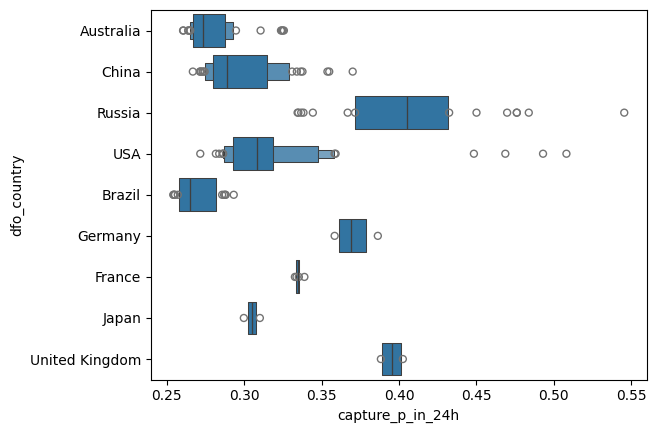

In [105]:
sns.boxenplot(data=big_countries, x="capture_p_in_24h", y="dfo_country")

Observations from plots:
- Capture probability was generated from latitude coordinate and exhibits a clear non-linear relationship with it.
- Rest of the features have small correlations with capture probability.
- Size related features are strongly correlated.
- Latitude affects capture probability
    - Floods caused by snow are more common in high latitudes and floods caused by (tropical) storms are more common in lower.
    - Floods are more likely to be caught in countries in lower latitudes.

## Model

Tree based models often offer good accuracy in wide variety of prediction tasks without needing a long time to tune model parameters correctly.

Some of our columns are categorical. Some ways to deal with categories are not applicable here:
- Can't convert to integers as there is no reasonable way rank categories between each other in this context.
- One-hot encoding leads to a sparse table which can be difficult for tree models.

Tree-based models can work poorly when asked to extrapolate data ranges not seen in training data. Global flood database in luckily very comprehensive.

With these considerations, we'll fit a gradient boosting based model with the [catboost](https://catboost.ai/) library.

In [3]:
floods_df = pd.read_csv('floods_df.tsv', sep='\t')

In [84]:
def make_model_data(data, columns, cat_columns = ['dfo_country', 'main_cause']):
    '''Create data for training a catboost model'''
    y = data.pop('capture_p_in_24h')
    X = data.filter(columns + cat_columns)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

    train_pool = Pool(X_train,
                      y_train,
                      cat_features=cat_columns)
    test_pool = Pool(X_test,
                     y_test,
                     cat_features=cat_columns)

    return(train_pool, test_pool, X_test.columns)

def show_model_performance(model, train_pool, test_pool, columns):
    '''Prints values to evaluate model performance'''

    train_metrics = model.eval_metrics(train_pool, metrics=['RMSE', 'R2'])
    test_metrics = model.eval_metrics(test_pool, metrics=['RMSE', 'R2'])

    print(f'R2 train: {train_metrics['R2'][-1]:.4f}')
    print(f'R2 test:  {test_metrics['R2'][-1]:.4f}')
    print(f'RMSE train: {train_metrics['RMSE'][-1]:.4f}')
    print(f'RMSE test:  {test_metrics['RMSE'][-1]:.4f}')

    df = pd.DataFrame({
        'feature': columns,
        'importance': model.get_feature_importance()
    })

    print(df)


In [29]:
train_pool, test_pool, model_columns = make_model_data(floods_df.copy(), columns)

model = CatBoostRegressor(loss_function='RMSE')
model.fit(train_pool)

Learning rate set to 0.037877
0:	learn: 0.0249021	total: 13.2ms	remaining: 13.2s
1:	learn: 0.0242841	total: 25ms	remaining: 12.5s
2:	learn: 0.0236891	total: 36.4ms	remaining: 12.1s
3:	learn: 0.0229988	total: 47.5ms	remaining: 11.8s
4:	learn: 0.0225242	total: 59.3ms	remaining: 11.8s
5:	learn: 0.0219524	total: 70.3ms	remaining: 11.7s
6:	learn: 0.0214596	total: 80.4ms	remaining: 11.4s
7:	learn: 0.0209357	total: 92.3ms	remaining: 11.4s
8:	learn: 0.0204593	total: 102ms	remaining: 11.3s
9:	learn: 0.0199281	total: 110ms	remaining: 10.9s
10:	learn: 0.0195277	total: 120ms	remaining: 10.8s
11:	learn: 0.0190531	total: 129ms	remaining: 10.6s
12:	learn: 0.0186866	total: 138ms	remaining: 10.5s
13:	learn: 0.0182857	total: 148ms	remaining: 10.4s
14:	learn: 0.0178494	total: 158ms	remaining: 10.4s
15:	learn: 0.0174802	total: 168ms	remaining: 10.3s
16:	learn: 0.0170602	total: 179ms	remaining: 10.4s
17:	learn: 0.0166495	total: 191ms	remaining: 10.4s
18:	learn: 0.0162674	total: 196ms	remaining: 10.1s
19:	l

In [30]:
show_model_performance(model, train_pool, test_pool, model_columns)

R2 train: 0.9996
R2 test:  0.9942
RMSE train: 0.0005
RMSE test:  0.0017
                 feature  importance
0         dfo_centroid_y   88.588299
1         dfo_centroid_x    0.783245
2            flood_width    2.891232
3           flood_height    0.862307
4             flood_area    1.265125
5           dfo_severity    0.927197
6   n_countries_affected    1.767388
7          dfo_displaced    0.430168
8               dfo_dead    0.274188
9            dfo_country    0.008771
10            main_cause    2.202080


Model has great fit. This is to be expected when latitude is included in the model. Importance scores show that other features hardly matter.

In [61]:
columns_no_latlon = ['capture_p_in_24h', 'flood_width','flood_height', 'flood_area', 'dfo_severity', 'n_countries_affected', 'dfo_displaced', 'dfo_dead']

In [62]:
train_pool, test_pool, model_columns = make_model_data(floods_df.copy(), columns_no_latlon)

model_no_lat = CatBoostRegressor(loss_function='RMSE', early_stopping_rounds=10)
model_no_lat.fit(train_pool)

Learning rate set to 0.037877
0:	learn: 0.0252810	total: 10.8ms	remaining: 10.8s
1:	learn: 0.0250285	total: 22.2ms	remaining: 11.1s
2:	learn: 0.0247377	total: 32.9ms	remaining: 10.9s
3:	learn: 0.0245296	total: 44.3ms	remaining: 11s
4:	learn: 0.0243334	total: 57ms	remaining: 11.3s
5:	learn: 0.0241129	total: 68.8ms	remaining: 11.4s
6:	learn: 0.0238869	total: 80ms	remaining: 11.3s
7:	learn: 0.0235471	total: 92.2ms	remaining: 11.4s
8:	learn: 0.0232571	total: 105ms	remaining: 11.5s
9:	learn: 0.0229199	total: 116ms	remaining: 11.4s
10:	learn: 0.0226185	total: 126ms	remaining: 11.3s
11:	learn: 0.0223630	total: 137ms	remaining: 11.2s
12:	learn: 0.0220955	total: 148ms	remaining: 11.2s
13:	learn: 0.0218767	total: 158ms	remaining: 11.2s
14:	learn: 0.0216469	total: 169ms	remaining: 11.1s
15:	learn: 0.0214087	total: 177ms	remaining: 10.9s
16:	learn: 0.0211768	total: 187ms	remaining: 10.8s
17:	learn: 0.0209415	total: 199ms	remaining: 10.8s
18:	learn: 0.0207212	total: 210ms	remaining: 10.9s
19:	learn

In [63]:
show_model_performance(model_no_lat, train_pool, test_pool, model_columns)

R2 train: 0.9615
R2 test:  0.6796
RMSE train: 0.0050
RMSE test:  0.0127
                feature  importance
0           flood_width   14.015896
1          flood_height   19.820216
2            flood_area    7.706593
3          dfo_severity    3.218618
4  n_countries_affected    5.208902
5         dfo_displaced    6.917210
6              dfo_dead    4.461639
7           dfo_country   24.546769
8            main_cause   14.104156


Without latitude and longitude features model does a worse job generalizing to test data. RMSE is still fairly low.

Test error continuing to decrease trough training doesn't indicate overfitting.



In [64]:
test_metrics = model_no_lat.eval_metrics(test_pool, metrics=['RMSE', 'R2'], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [34]:
model_no_lat.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType

In [67]:
model_tuned = CatBoostRegressor(loss_function='RMSE', early_stopping_rounds=10)
param_grid = {
    'iterations': [500, 2000],
    'depth': [4, 6, 8],
    'learning_rate': [0.03, 0.1]
}
grid_search_results = model_tuned.grid_search(param_grid, train_pool, cv=3, partition_random_seed=42)
best_params = grid_search_results['params']

print("Best Hyperparameters:")
print(best_params)

show_model_performance(model_tuned, train_pool, test_pool, model_columns)

0:	learn: 0.1539900	test: 0.1542841	best: 0.1542841 (0)	total: 8.9ms	remaining: 4.44s
1:	learn: 0.1498069	test: 0.1501291	best: 0.1501291 (1)	total: 17.4ms	remaining: 4.33s
2:	learn: 0.1454814	test: 0.1458485	best: 0.1458485 (2)	total: 22.5ms	remaining: 3.72s
3:	learn: 0.1415439	test: 0.1419510	best: 0.1419510 (3)	total: 30ms	remaining: 3.72s
4:	learn: 0.1375585	test: 0.1379710	best: 0.1379710 (4)	total: 38ms	remaining: 3.76s
5:	learn: 0.1337890	test: 0.1342180	best: 0.1342180 (5)	total: 45.3ms	remaining: 3.73s
6:	learn: 0.1300538	test: 0.1304898	best: 0.1304898 (6)	total: 53.2ms	remaining: 3.75s
7:	learn: 0.1263579	test: 0.1267858	best: 0.1267858 (7)	total: 59ms	remaining: 3.63s
8:	learn: 0.1227389	test: 0.1231759	best: 0.1231759 (8)	total: 61.2ms	remaining: 3.34s
9:	learn: 0.1193849	test: 0.1198459	best: 0.1198459 (9)	total: 69ms	remaining: 3.38s
10:	learn: 0.1160584	test: 0.1165251	best: 0.1165251 (10)	total: 76.6ms	remaining: 3.4s
11:	learn: 0.1128417	test: 0.1133177	best: 0.113317

Hyperparameter tuning shows that initial default values were good for the problem.